#### Importings

In [1]:
import os 
import time
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F
from DataHandling_3 import DataLoaderLite
import DataHandling_3
from GPT import GPT
import Parameters

val_loss_plt_list = []
train_loss_plt_list = []
lr_rate_plt_list = []
eval_interval_c = 0

Token sayısı: 20000
warm up steps: 9


#### Initializing the Device

In [2]:
# set up DDP (distributed data parallel).
# torchrun command sets the env variables RANK, LOCAL_RANK, and WORLD_SIZE
ddp = int(os.environ.get('RANK', -1)) != -1 # is this a ddp run?
ddp_rank = 0
ddp_local_rank = 0
ddp_world_size = 1
# vanilla, non-DDP run
master_process = True
# attempt to autodetect device
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print(f"using device: {device}")

device_type = "cuda" if device.startswith("cuda") else "cpu"

using device: cpu


#### Killing randomness

In [3]:
# Model her çalıştığında aynı sonuçlar alınacak
torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

#### Data is divided into two as Validation and Train and made ready

In [4]:
assert Parameters.total_batch_size % (Parameters.B * Parameters.T * ddp_world_size) == 0, "make sure total_batch_size is divisible by B * T * ddp_world_size"
grad_accum_steps = Parameters.total_batch_size // (Parameters.B * Parameters.T * ddp_world_size)
if master_process:
    print(f"total desired batch size: {Parameters.total_batch_size}")
    print(f"=> calculated gradient accumulation steps: {grad_accum_steps}")

train_loader = DataLoaderLite(B=Parameters.B, T=Parameters.T, process_rank=ddp_rank, num_processes=ddp_world_size, split="train")
val_loader = DataLoaderLite(B=Parameters.B, T=Parameters.T, process_rank=ddp_rank, num_processes=ddp_world_size, split="val")

torch.set_float32_matmul_precision('high')

total desired batch size: 2048
=> calculated gradient accumulation steps: 1
Loaded 266677 tokens
1 epoch = 130 batches
Loaded 266677 tokens
1 epoch = 130 batches


#### Initializing the Model

In [5]:
# create model
model = GPT(Parameters.GPTConfig(vocab_size=DataHandling_3.vocab_size))
# model = GPT.from_pretrained("gpt2") # or init from OpenAI GPT-2
model.to(device)
use_compile = False # torch.compile interferes with HellaSwag eval and Generation. TODO fix
if use_compile:
    model = torch.compile(model)
raw_model = model.module if ddp else model # always contains the "raw" unwrapped model

def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    #return Parameters.max_lr #TODO
    if it < Parameters.warmup_steps:
        return Parameters.max_lr * (it+1) / Parameters.warmup_steps
    # 2) if it > lr_decay_iters, return min learning rate
    if it > Parameters.max_steps:
        return Parameters.min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - Parameters.warmup_steps) / (Parameters.max_steps - Parameters.warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return Parameters.min_lr + coeff * (Parameters.max_lr - Parameters.min_lr)

#### Initializing the Optimizer

In [6]:
optimizer = raw_model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4, device_type=device_type)

#### Creating a File to Store Saved Models 

In [7]:
# create the log directory we will write checkpoints to and log to
log_dir = "log"
os.makedirs(log_dir, exist_ok=True)
log_file = os.path.join(log_dir, f"log.txt")
with open(log_file, "w") as f: # open for writing to clear the file
    pass

### Training

In [8]:
for step in range(Parameters.max_steps):
    t0 = time.time()
    last_step = (step == Parameters.max_steps - 1)

    # once in a while evaluate our validation loss
    if step % Parameters.eval_interval == 0 or last_step:
        model.eval()
        val_loader.reset()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 20
            for _ in range(val_loss_steps):
                x, y = val_loader.next_batch()
                x, y = x.to(device), y.to(device)
                with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                    logits, loss = model(x, y)
                loss = loss / val_loss_steps
                val_loss_accum += loss.detach()
        if master_process:
            eval_interval_c += 1
            val_loss_plt_list.append(val_loss_accum.item())
                
            if step > 0 and (step % 5000 == 0 or last_step):
                # optionally write model checkpoints
                checkpoint_path = os.path.join(log_dir, f"model_{step:05d}.pt")
                checkpoint = {
                    'model': raw_model.state_dict(),
                    'config': raw_model.config,
                    'step': step,
                    'val_loss': val_loss_accum.item()
                }
                # you might also want to add optimizer.state_dict() and
                # rng seeds etc., if you wanted to more exactly resume training
                torch.save(checkpoint, checkpoint_path)
            
    # do one step of the optimization
    model.train()
    optimizer.zero_grad()
    loss_accum = 0.0
    for micro_step in range(grad_accum_steps):
        x, y = train_loader.next_batch()
        x, y = x.to(device), y.to(device)
        # added after video, this field is also used by the forward pass.
        with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
            logits, loss = model(x, y)
        # we have to scale the loss to account for gradient accumulation,
        # because the gradients just add on each successive backward().
        # addition of gradients corresponds to a SUM in the objective, but
        # instead of a SUM we want MEAN. Scale the loss here so it comes out right
        loss = loss / grad_accum_steps
        loss_accum += loss.detach()
        loss.backward()

    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # determine and set the learning rate for this iteration
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    optimizer.step()
    if device_type == "cuda":
        torch.cuda.synchronize() # wait for the GPU to finish work
    t1 = time.time()
    dt = t1 - t0 # time difference in seconds
    tokens_processed = train_loader.B * train_loader.T * grad_accum_steps * ddp_world_size
    tokens_per_sec = tokens_processed / dt
    
    if master_process:
        print(f"step {step:5d} | train loss: {loss_accum.item():.6f} | lr {lr:.4e} | norm: {norm:.4f} | dt: {dt*1000:.2f}ms | tok/sec: {tokens_per_sec:.2f}")
        
        # Log training loss and learning rate
        train_loss_plt_list.append(loss_accum.item())
        lr_rate_plt_list.append(lr)

step     0 | train loss: 9.970126 | lr 3.3333e-05 | norm: 18.4138 | dt: 195145.53ms | tok/sec: 10.49
step     1 | train loss: 9.232653 | lr 6.6667e-05 | norm: 9.0478 | dt: 26359.98ms | tok/sec: 77.69
step     2 | train loss: 9.022935 | lr 1.0000e-04 | norm: 5.6284 | dt: 24549.96ms | tok/sec: 83.42
step     3 | train loss: 9.248116 | lr 1.3333e-04 | norm: 5.4631 | dt: 28140.59ms | tok/sec: 72.78
step     4 | train loss: 8.864522 | lr 1.6667e-04 | norm: 3.3097 | dt: 27181.15ms | tok/sec: 75.35
step     5 | train loss: 8.701635 | lr 2.0000e-04 | norm: 2.1357 | dt: 27248.79ms | tok/sec: 75.16
step     6 | train loss: 8.559882 | lr 2.3333e-04 | norm: 1.9815 | dt: 26800.23ms | tok/sec: 76.42
step     7 | train loss: 8.481154 | lr 2.6667e-04 | norm: 1.7197 | dt: 26779.83ms | tok/sec: 76.48
step     8 | train loss: 8.401109 | lr 3.0000e-04 | norm: 1.7896 | dt: 27357.56ms | tok/sec: 74.86
step     9 | train loss: 8.304694 | lr 3.0000e-04 | norm: 1.9745 | dt: 26935.06ms | tok/sec: 76.03
step    

#### Visiulazation the Validaiton and Training rate

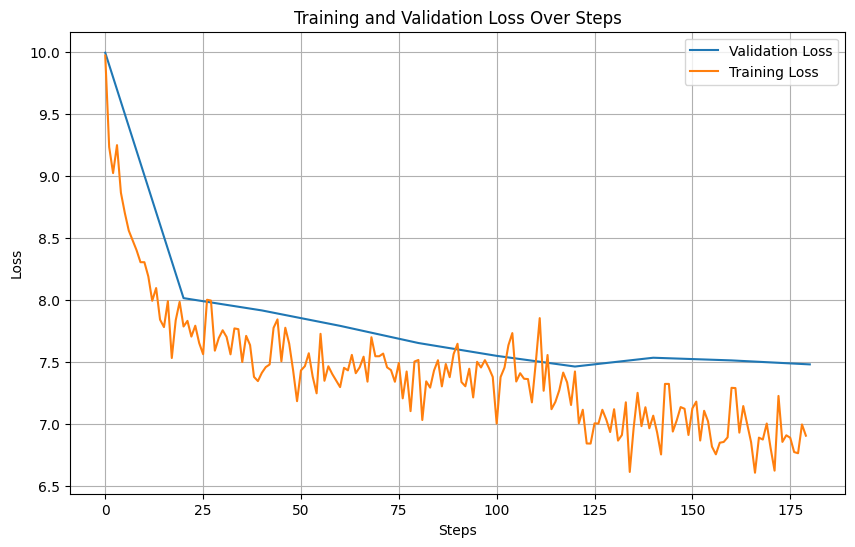

In [9]:
steps_v = np.linspace(0, Parameters.max_steps, eval_interval_c)
steps_t = range(Parameters.max_steps)
plt.figure(figsize=(10, 6))
plt.plot(steps_v, val_loss_plt_list, label='Validation Loss')
plt.plot(steps_t, train_loss_plt_list, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Steps')
plt.legend()
plt.grid(True)
plt.show()

#### Visiulazation the Learning rate

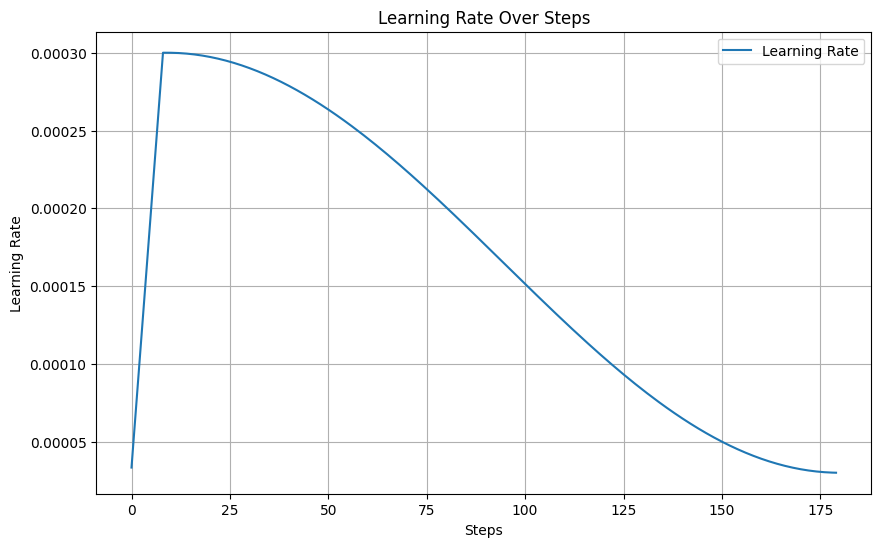

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(Parameters.max_steps), lr_rate_plt_list, label='Learning Rate')
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Over Steps')
plt.legend()
plt.grid(True)
plt.show()

#### Uploading Saved Model

In [18]:
# Checkpoint dosyasının yolu
checkpoint_path = os.path.join(log_dir, 'model_00179.pt')  # Örnek olarak 5000. adım

# Checkpoint'i yükle
checkpoint = torch.load(checkpoint_path)

# Modelin konfigürasyonunu al
config = checkpoint['config']

# Modeli oluştur ve state_dict'i yükle
model = GPT(config)
model.load_state_dict(checkpoint['model'])

# Modeli evaluation moduna al
model.eval()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(20000, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=20000, bias=False)
)

#### Generating from Saved Model

In [19]:
def generate_text(model, tokens, max_length=Parameters.max_length, top_k=Parameters.top_k, temperature=Parameters.temperature):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tokens = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)  # tokens'ı tensor yapıp device'a taşı
    generated = tokens

    for _ in range(max_length - tokens.size(1)):
        with torch.no_grad():
            outputs = model(generated)
            logits = outputs[0]
            next_token_logits = logits[0, -1, :] / temperature

            # Top-k sampling
            top_k_logits, top_k_indices = torch.topk(next_token_logits, top_k)
            probs = F.softmax(top_k_logits, dim=-1)
            next_token = torch.multinomial(probs, 1)

            generated = torch.cat((generated, top_k_indices[next_token].unsqueeze(0)), dim=1)

    generated_text = DataHandling_3.decode(generated.squeeze().tolist())
    return generated_text

#### Giving Prompt

In [1]:
# Girdi metni
prompt = "ermeniler"

# Metni tokenize et
tokens = DataHandling_3.encode(prompt)

# Generate text
generated_text = generate_text(model, tokens)
print(generated_text)

NameError: name 'DataHandling_3' is not defined